<a href="https://colab.research.google.com/github/Varogell/PCVK_Ganjil_2023/blob/main/Week10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Import Library

!pip install pytesseract

import cv2 as cv
import numpy as np
import pytesseract
import matplotlib.pyplot as plt
import pandas as pd
from PIL import Image

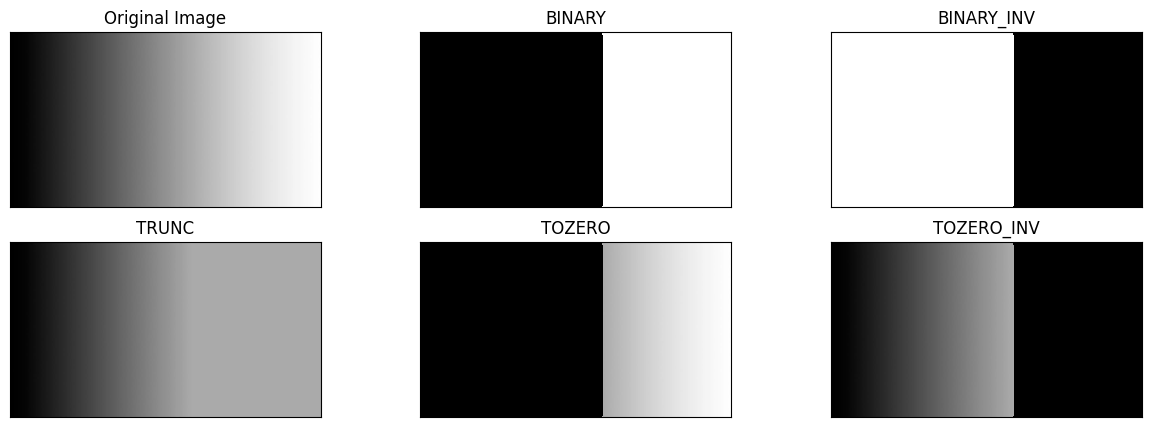

In [ ]:
# Read Image
filename = ('/content/drive/MyDrive/PCVK2023/Images/gradient.jpg')
img = cv.imread(filename)
thresh1 = cv.imread(filename)
thresh2 = cv.imread(filename)
thresh3 = cv.imread(filename)
thresh4 = cv.imread(filename)
thresh5 = cv.imread(filename)
thresh = 170 #nilai Threshold yang ditentukan
#1. thresh1 jika pixel di img>127, maka thresh1 bernilai 1(putih) selain itu bernilai 0(hitam)
thresh1[img>thresh] = 255 #tanpa library
thresh1[img<=thresh] = 0
#2. thresh2 adalah binary threshold inverse
thresh2 = 255 - thresh1 #tanpa library
#3. Threshold Truncate
thresh3[img>thresh] = thresh #tanpa library
#4. Threshold Tozero
thresh4[img<=thresh] = 0 #tanpa library
#5. Threshold Tozero Inverse
thresh5[img>thresh] = 0 #tanpa library

titles = ['Original Image','BINARY','BINARY_INV','TRUNC', 'TOZERO', 'TOZERO_INV']
images = [img, thresh1, thresh2, thresh3, thresh4, thresh5]
plt.figure(figsize = (15,5))
for i in range(len(images)):
  plt.subplot(2,3,i+1),plt.imshow(images[i],'gray', interpolation='nearest')
  plt.title(titles[i])
  plt.xticks([]),plt.yticks([])
plt.show()

Otsu's Threshold: 167


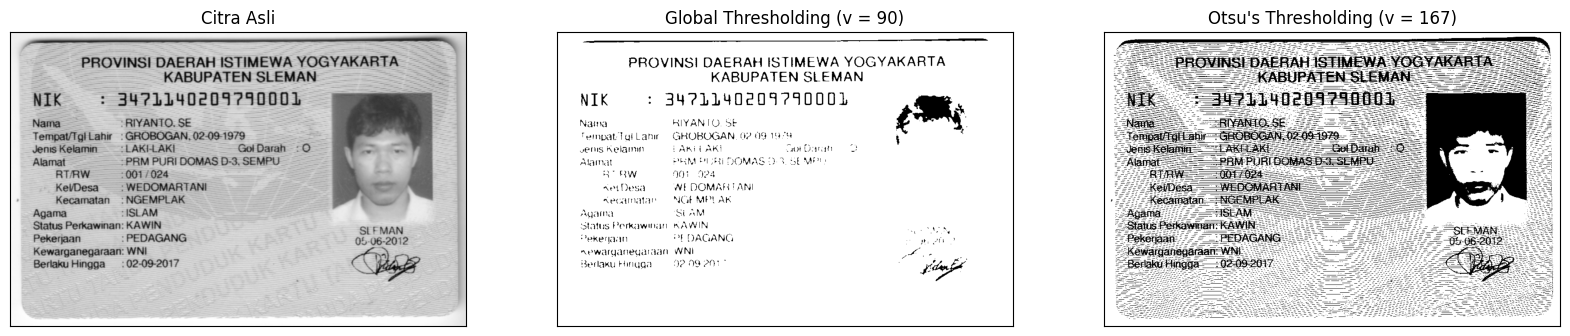

In [ ]:
filename = ('/content/drive/MyDrive/PCVK2023/Images/KTP_More/ktp.png')
img = cv.imread(filename, 0)
blur = cv.GaussianBlur(img, (5, 5), 0)

def otsu(gray):
    pixel_number = gray.shape[0] * gray.shape[1]
    mean_weight = 1.0 / pixel_number

    his, bins = np.histogram(gray, np.arange(0, 257))
    final_thresh = -1
    final_value = -1
    intensity_arr = np.arange(256)

    for t in bins[1:-1]:
        pcb = np.sum(his[:t])
        pcf = np.sum(his[t:])
        Wb = pcb * mean_weight
        Wf = pcf * mean_weight
        mub = np.sum(intensity_arr[:t] * his[:t]) / float(pcb)
        muf = np.sum(intensity_arr[t:] * his[t:]) / float(pcf)

        value = Wb * Wf * (mub - muf) ** 2
        if value > final_value:
            final_thresh = t
            final_value = value

    final_img = gray.copy()
    print("Otsu's Threshold:", final_thresh)
    final_img[gray > final_thresh] = 255
    final_img[gray < final_thresh] = 0
    return final_img, final_thresh

otsu_biner, otsu_thresh = otsu(img)
x = "Otsu's Thresholding (v = " + str(otsu_thresh) + ")"

ret, th1 = cv.threshold(blur, 90, 255, cv.THRESH_BINARY)

titles = ['Citra Asli', 'Global Thresholding (v = 90)', x]
citra3 = [blur, th1, otsu_biner]

plt.figure(figsize=(20, 15))
for i in range(len(citra3)):
    plt.subplot(1, 3, i + 1), plt.imshow(citra3[i], 'gray')
    plt.title(titles[i])
    plt.xticks([]), plt.yticks([])

plt.show()

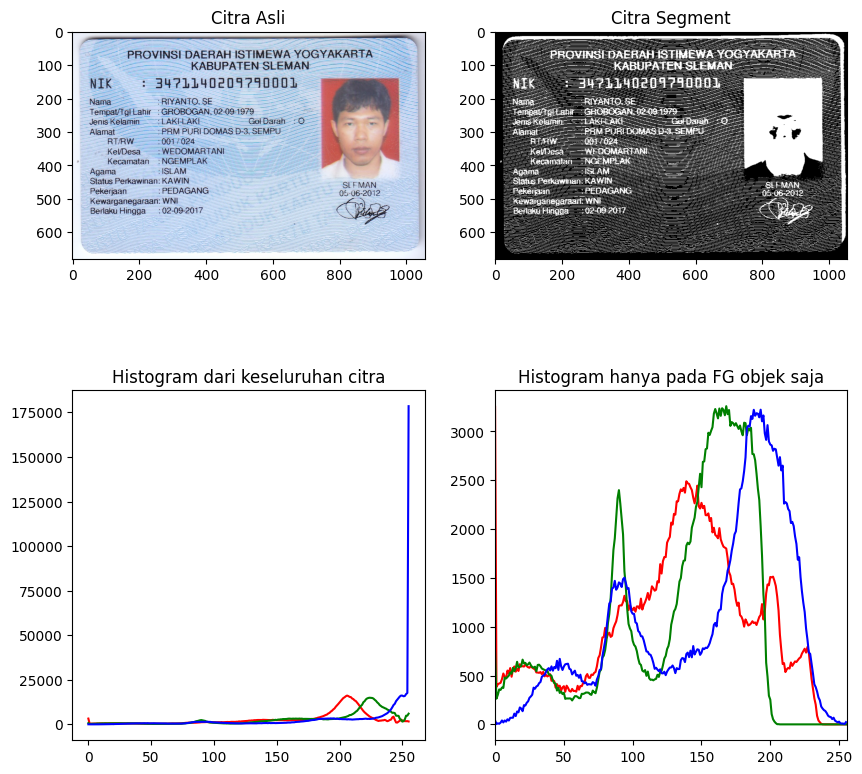

In [ ]:
import cv2 as cv
import matplotlib.pyplot as plt

filename = '/content/drive/MyDrive/PCVK2023/Images/KTP_More/ktp.png'
img = cv.imread(filename)
img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
img_gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
ret3, mask = cv.threshold(img_gray, 200, 255, cv.THRESH_BINARY_INV)
plt.figure(figsize=(10, 10))
plt.subplot(2, 2, 1), plt.imshow(img)
plt.title('Citra Asli')
plt.subplot(2, 2, 2), plt.imshow(mask, 'gray')
plt.title('Citra Segment')

color = ('r', 'g', 'b')
for i, col in enumerate(color):
    hist0 = cv.calcHist([img], [i], None, [256], [0, 256])
    plt.subplot(2, 2, 3), plt.plot(hist0, color=col)
    plt.title('Histogram dari keseluruhan citra')
    hist1 = cv.calcHist([img], [i], mask, [256], [0, 256])
    plt.subplot(2, 2, 4), plt.plot(hist1, color=col)
    plt.title('Histogram hanya pada FG objek saja')
    plt.xlim([0, 256])

plt.show()


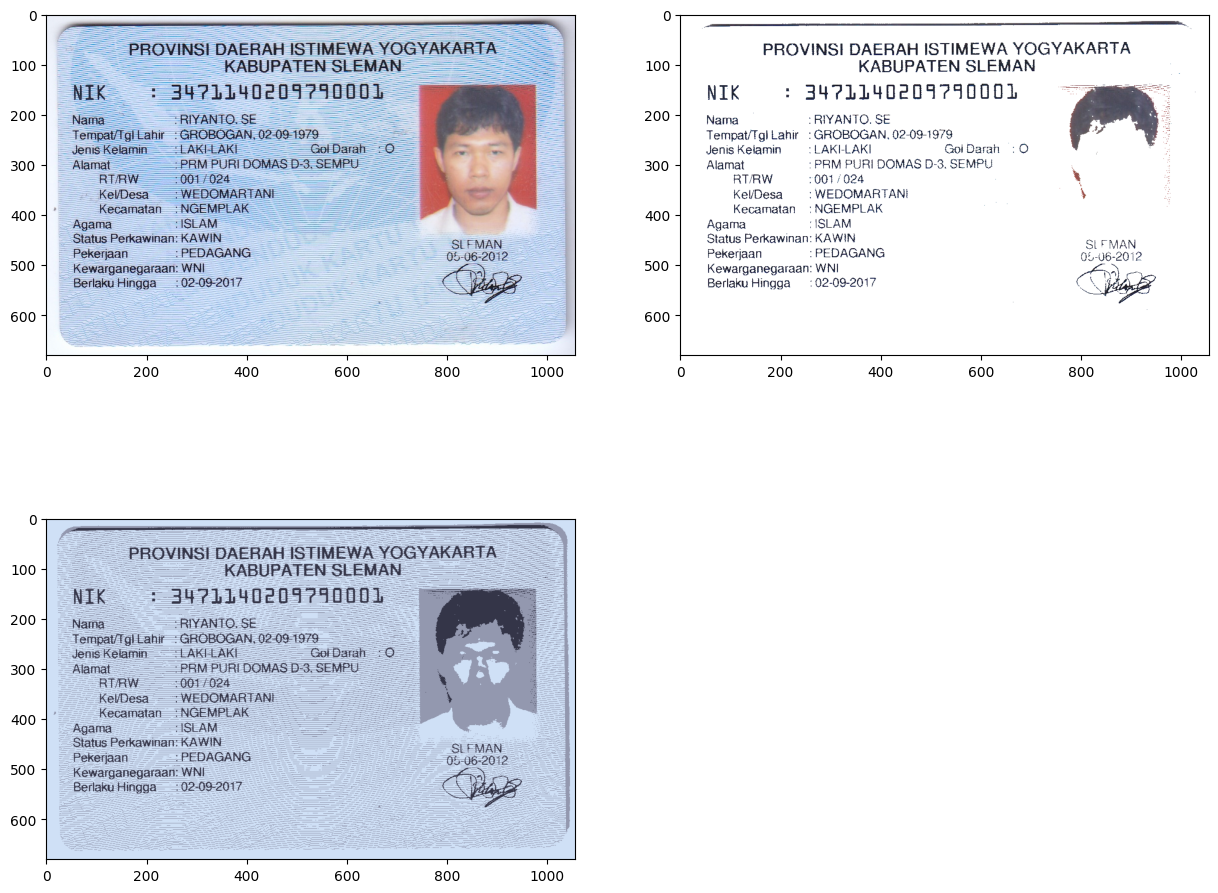

In [ ]:
filename = '/content/drive/MyDrive/PCVK2023/Images/KTP_More/ktp.png'
img = cv.imread(filename)
img = cv.cvtColor(img, cv.COLOR_BGR2RGB)

'''
Kita akan menggunakan fungsi cv.kmeans() yang meminta array 2D sebagai masukan,
sedangkan image aslinya adalah array 3D. Selanjutnya kita perlu melakukan flattening array image masukan
'''
# reshape array ke bentuk 2D
pixel_values = img.reshape((-1, 3))
# convert to float
pixel_values = np.float32(pixel_values)

'''
Syarat berhenti iterasi dari KMeans adalah jika centroid tidak terlalu banyak pergeseran posisi antara
iterasi sekarang dengan iterasi sebelumnya (konvergen). Karena jumlah data yang besar, maka kita akan hentikan iterasi saat jumlah iterasi = 150 atau epsilon (selisih antara posisi centroid sekarang dengan posisi centroid di iterasi sebelumnya) < 0.1
'''
criteria = (cv.TERM_CRITERIA_EPS + cv.TERM_CRITERIA_MAX_ITER, 150, 0.1)

'''
Jika diperhatikan pada image asli, terdapat 3 warna utama (hijau, biru, dan putih/orange). Untuk percobaan ini kita akan gunakan 3 cluster untuk image ini
'''
k = 3
_, labels, (centers)= cv.kmeans(pixel_values, k, None, criteria, 10, cv.KMEANS_RANDOM_CENTERS)
# konversi titik centroid kedalam integer
centers = np.uint8(centers)
# flattening label array
labels = labels.flatten()
# konversi warna pixel asli kewarna dari tiap centroidnya
segmented_image = centers[labels.flatten()]
# reshape ke bentuk image asli
segmented_image = segmented_image.reshape(img.shape)
masked_image = np.copy(img)
masked_image0 = masked_image.reshape((-1, 3))
masked_image0[labels != 1] = [255, 255, 255]
masked_image0 = masked_image0.reshape(img.shape)

plt.figure(figsize=(15, 12))
plt.subplot(2, 2, 1), plt.imshow(img)
plt.subplot(2, 2, 2), plt.imshow(masked_image0)
plt.subplot(2, 2, 3), plt.imshow(segmented_image)
plt.show()


Proses konversi gambar KTP menjadi teks yang dapat mengenali tulisan

In [ ]:
!pip install pytesseract
!sudo apt-get install tesseract-ocr-ind

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
tesseract-ocr-ind is already the newest version (1:4.00~git30-7274cfa-1.1).
0 upgraded, 0 newly installed, 0 to remove and 19 not upgraded.


In [ ]:
def display(img,cmap='gray'):
  fig = plt.figure(figsize=(12,10))
  ax = fig.add_subplot(111)
  ax.imshow(img,cmap='gray')

Python-tesseract akan mencetak teks yang dikenali dan menyimpannya kedalam file

In [ ]:
from pytesseract import Output
img = cv.imread('/content/drive/MyDrive/PCVK2023/Images/KTP_More/ktp.png')
d = pytesseract.image_to_data(img, output_type=Output.DICT)
print(d.keys())

dict_keys(['level', 'page_num', 'block_num', 'par_num', 'line_num', 'word_num', 'left', 'top', 'width', 'height', 'conf', 'text'])


Menambahkan kotak untuk deteksi teksi pada gambar

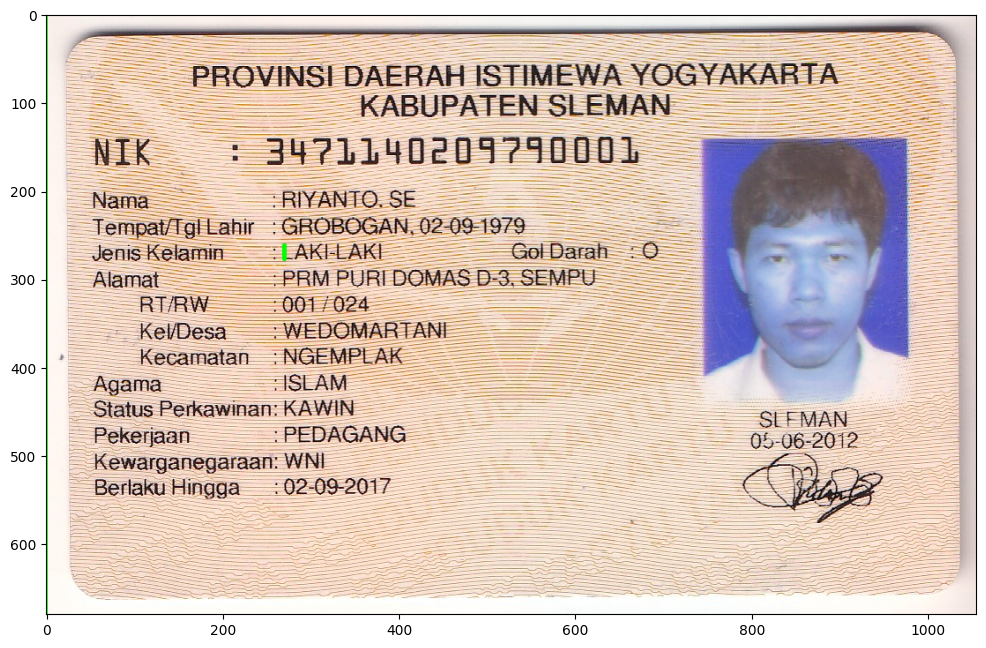

In [ ]:
n_boxes = len(d['text'])
for i in range(n_boxes):
  if int(d['conf'][i]) > 60:
    (x, y, w, h) = (d['left'][i], d['top'][i], d['width'][i], d['height'][i])
    img = cv.rectangle(img, (x, y), (x + w, y + h), (0, 255, 0), 2)
display(img)

Hasil pembacaan KTP Menjadi text

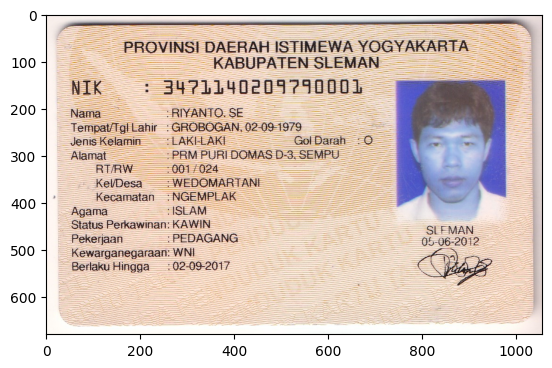

em

PROVINSI DAERAH ISTIMEWA YOGYAKARTA
KABUPATEN SLEMAN

 

NIK : 34711140209790001

Nama :RIYANTO. SE

Tempat/Tgl Lahir : GROBOGAN. 02-09-1979

Jenis Kelamin : LAKI-LAKI Gol Darah : 0

Alamat PRM PURI DOMAS D-3. SEMPU
RTRW 1001 1024

Kel/Desa : WEDOMARTANI!
Kecamatan : NGEMPLAK

Agama "ISLAM
Status Bean KAWIN SLEMAN
Pekerjaan : PEDAGANG 05-06-2012

Kewarganegaraan: WNI HI —
Berlaku Hingga :02-09-2017 NIA

   
 

 



In [ ]:
img = cv.imread('/content/drive/MyDrive/PCVK2023/Images/KTP_More/ktp.png')
plt.imshow(img)
plt.show()

gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
th, threshed = cv.threshold(gray, 127, 255, cv.THRESH_TRUNC)
text1 = pytesseract.image_to_data(threshed, output_type='data.frame')
text2 = pytesseract.image_to_string(threshed, lang="ind")
print(text2)

text = text1[text1.conf != -1]
lines = text.groupby('block_num')['text'].apply(list)
conf = text.groupby(['block_num'])['conf'].mean()

# Tugas implementasi citra dengan Global Thresholding dan hasil ekstrak teks dari KTP

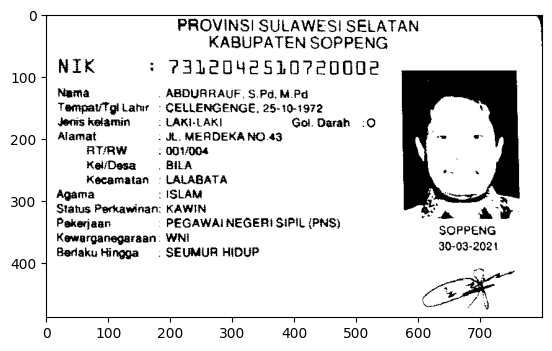


Hasil Ekstrak Teks

NIK :

Nama
Tempat/Tgi Lahir
Joris kelamin
Alamat
RTRW
Kel/Desa
Kecamatan
Agama
Status Perkawinan:
Pekerjaan
Kewarganegaraan
Beriaku Hingga

PROVINSI SULAWESI SELATAN

   

KABUPATEN SOPPENG

?312012510720002
ABDURRAUF. S.Pd, M.Pd

! GELLENGENGE, 25-10-1972

2 LAKI-LAKI Gol. Derah :0

LIL. MERDEKANO.43

: ooyooa

. BILA
LALABATA

ISLAM 3 3
KAWIN 3 49
PEGAWAI NEGERI SIPIL (PNS) Sepena
WNI 30-03-2021

: SEUMUR HIDUP



In [ ]:
# Baca citra KTP
img = cv.imread('/content/drive/MyDrive/PCVK2023/Images/KTP.jpeg')
ktp_gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)

# Terapkan global thresholding pada citra KTP
global_threshold, ktp_threshold = cv.threshold(ktp_gray, 111, 255, cv.THRESH_BINARY)

# Tampilkan citra hasil thresholding
plt.imshow(ktp_threshold, cmap='gray')
plt.show()

# Ekstrak teks dari citra hasil thresholding
extracted_text = pytesseract.image_to_string(ktp_threshold, lang="ind")

# Tampilkan teks yang diekstrak
print("\nHasil Ekstrak Teks\n\n"+extracted_text)